In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [3]:
data = tf.keras.datasets.mnist.load_data()
batch_size = 512
img_size = data[0][0].shape[1]
num_channels = 1 if len(data[0][0].shape) == 3 else 3
class_names = list(set(data[0][1].flatten()))
num_classes = len(class_names)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
def prepare_data(data):
    (train_images, train_labels), (test_images, test_labels) = data
    train_labels, test_labels = np.eye(num_classes)[train_labels.flatten()], np.eye(num_classes)[test_labels.flatten()]
    if len(train_images.shape) == 3:
        train_images, test_images = np.expand_dims(train_images, -1), np.expand_dims(test_images, -1)
    return (train_images, train_labels), (test_images, test_labels)


(train_images, train_labels), (test_images, test_labels) = prepare_data(data)
train_len = train_images.shape[0]

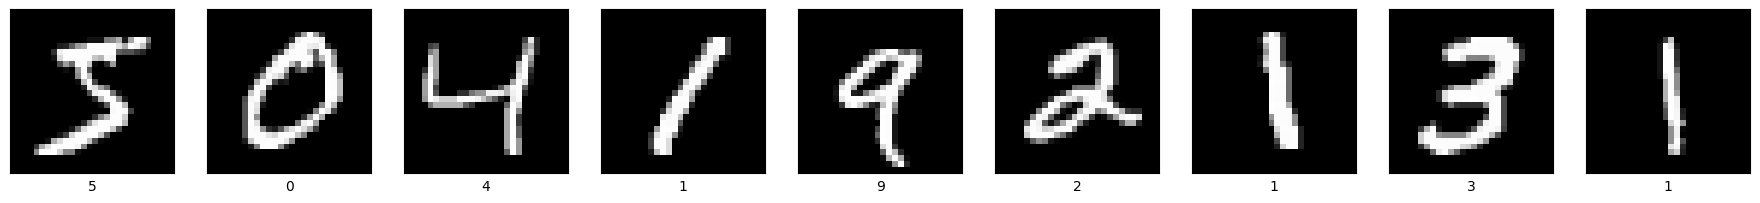

In [5]:
plt.figure(figsize=(25, 25))
for i in range(9):
    plt.subplot(1, num_classes, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(class_names[data[0][1].flatten()[i]])
plt.show()

In [6]:
def normalizer(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def create_dataset(X, y, is_train=True):
    if is_train:
        cache_val = True
        shuffle_val = True
        repeat_val = True
    else:
        cache_val = False
        shuffle_val = False
        repeat_val = False

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(normalizer, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if cache_val:
        dataset = dataset.cache()

    if shuffle_val:
        dataset = dataset.shuffle(buffer_size=dataset.cardinality(), reshuffle_each_iteration=True)

    if repeat_val:
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.prefetch(tf.data.AUTOTUNE)

In [8]:
train_dataset = create_dataset(X=train_images, y=train_labels)
test_dataset = create_dataset(X=test_images, y=test_labels, is_train=False)
train_steps = int(np.ceil(train_len / batch_size))

In [9]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, monitor, threshold, max_epochs, patience=3):
        super(EarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.threshold = threshold
        self.best_weights = None
        self.max_epochs = max_epochs
        self.best_monitoring_value = float('-inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_monitoring_value = logs.get(self.monitor)
        if current_monitoring_value is None:
            raise ValueError(f"The metric {self.monitor} is not available in logs for early stopping.")
        if epoch >= self.max_epochs - 1:
            print(f"\n--- Early stopping: Reached maximum number of epochs : {self.max_epochs} \n")
            self.model.set_weights(self.best_weights)
            self.model.stop_training = True
            return
        if current_monitoring_value > self.best_monitoring_value:
            self.best_weights = self.model.get_weights()
            self.best_monitoring_value = current_monitoring_value
        if current_monitoring_value < self.threshold:
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.set_weights(self.best_weights)
                self.model.stop_training = True
                print(
                    f"\n--- Early stopping: {self.monitor} has been more than {self.threshold} for {self.patience} epochs.\n")
                return


def plot_loss_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    return


def plot_confusion_matrix(model):
    y_test_preds = model.predict(test_dataset)
    y_test_preds = np.argmax(y_test_preds, axis=1)
    y_test = np.concatenate([y for x, y in test_dataset], axis=0)
    y_test = y_test.argmax(axis=1)
    cm = confusion_matrix(y_test, y_test_preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
    plt.title('Confusion matrix')
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.colorbar()
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.rcParams['font.size'] = '14'
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return

In [10]:
subpatch_dim = 14
num_subpatches = int((img_size / subpatch_dim) ** 2)
projection_dim = 768
num_heads = 12
num_blocks = 12
mlp_head_size = 512
dropout_rate = 0.3

In [11]:
images = test_dataset.take(1).get_single_element()[0]

batch = tf.shape(images)[0]
patches = tf.image.extract_patches(
    images=images,
    sizes=[1, subpatch_dim, subpatch_dim, 1],
    strides=[1, subpatch_dim, subpatch_dim, 1],
    rates=[1, 1, 1, 1],
    padding="VALID",
)
patches = tf.reshape(patches, [batch, -1, subpatch_dim, subpatch_dim, num_channels])

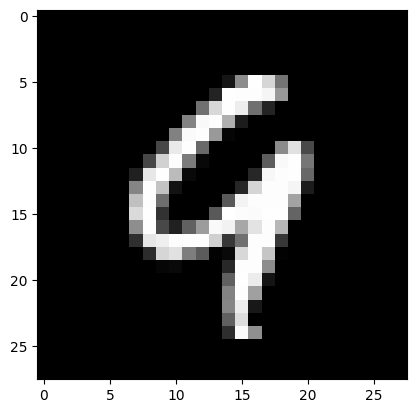

In [12]:
index = np.random.randint(0, batch_size, (1,))[0]
plt.imshow(images[index], cmap=plt.cm.gray, interpolation='nearest')

In [13]:
patches.shape

TensorShape([512, 4, 14, 14, 1])

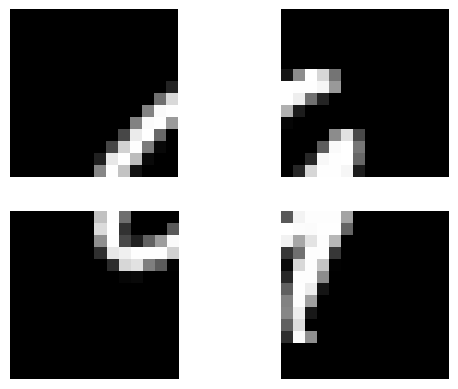

In [14]:
n = int(np.sqrt(patches.shape[1]))
for i, patch in enumerate(patches[index]):
    ax = plt.subplot(n, n, i + 1)
    ax.imshow(patch.numpy(), cmap=plt.cm.gray, interpolation='nearest')
    ax.axis("off")

In [15]:
class PatchExtractor(tf.keras.layers.Layer):
    def __init__(self):
        super(PatchExtractor, self).__init__()

    def call(self, images):
        batch = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, subpatch_dim, subpatch_dim, 1],
            strides=[1, subpatch_dim, subpatch_dim, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        return tf.reshape(patches, [batch, num_subpatches, subpatch_dim * subpatch_dim * num_channels])


class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        w_init = tf.random_normal_initializer()
        class_token = w_init(shape=(1, projection_dim), dtype="float32")
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(input_dim=num_patches + 1, output_dim=projection_dim)

    def call(self, patch):
        batch = tf.shape(patch)[0]
        # reshape the class token embeddings
        class_token = tf.tile(self.class_token, multiples=[batch, 1])
        class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))

        # calculate patches embeddings
        patches_embed = self.projection(patch)
        patches_embed = tf.concat([patches_embed, class_token], 1)

        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)
        positions_embed = self.position_embedding(positions)

        # add both embeddings
        return patches_embed + positions_embed


class FeedForward(tf.keras.layers.Layer):
    def __init__(self, hidden_features, out_features, dropout_rate):
        super(FeedForward, self).__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_features, activation='gelu')
        self.dense2 = tf.keras.layers.Dense(out_features)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return self.dropout(x)


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, projection_dim, num_heads, dropout_rate):
        super(TransformerBlock, self).__init__()
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim // num_heads,
                                                       dropout=dropout_rate)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ff = FeedForward(projection_dim * 4, projection_dim, dropout_rate)

    def call(self, x):
        x1 = self.norm1(x)
        attention_output = self.attn(x1, x1)
        x2 = tf.keras.layers.Add()([attention_output, x])
        x3 = self.norm2(x2)
        x3 = self.ff(x3)
        return tf.keras.layers.Add()([x3, x2])


class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, projection_dim, num_heads, num_blocks, dropout_rate):
        super(TransformerEncoder, self).__init__()
        self.blocks = [TransformerBlock(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        return self.dropout(x)


class FeedForwardHead(tf.keras.layers.Layer):
    def __init__(self, hidden_neurons, dropout_rate):
        super(FeedForwardHead, self).__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_neurons, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(hidden_neurons // 2, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(hidden_neurons // 4, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(len(class_names), activation='softmax')
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.dense3(x)
        x = self.dropout(x)
        return self.dense4(x)


class VisionTransformer:
    def __VisionTransformer(self, input_shape):
        input_layer = tf.keras.layers.Input(shape=input_shape, name='image_input')

        patches = PatchExtractor()(input_layer)
        patches_embed = PatchEncoder(num_subpatches, projection_dim)(patches)

        representation = TransformerEncoder(projection_dim, num_heads, num_blocks, dropout_rate)(patches_embed)

        return tf.keras.models.Model(inputs=input_layer, outputs=representation[:, 0, :], name='VisionTransformer')

    def build_model(self, input_shape):
        base_model = self.__VisionTransformer(input_shape=input_shape)
        fc = FeedForwardHead(mlp_head_size, dropout_rate)(base_model.output)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='VisionTransformer_Classifier')

In [16]:
vit = VisionTransformer().build_model(input_shape=(img_size, img_size, num_channels))
vit.summary()

Model: "VisionTransformer_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_extractor                 │ (None, 4, 196)         │             0 │
│ (PatchExtractor)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder (PatchEncoder)    │ (None, 5, 768)         │       155,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 5, 768)         │    85,056,000 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item (GetItem)              │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feed_forward_head               │ (None, 10)             │       559,242 │
│ (FeedForwardHead)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,770,378 (327.19 MB)

 Trainable params: 85,770,378 (327.19 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_vit.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

MAX_EPOCHS = 50

early_stopping = EarlyStopping(monitor='val_accuracy', threshold=0.95, max_epochs=MAX_EPOCHS, patience=3)

vit.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
vit_history = vit.fit(train_dataset,
                      epochs=MAX_EPOCHS,
                      steps_per_epoch=train_steps,
                      validation_data=test_dataset,
                      callbacks=[early_stopping, checkpoint],
                      verbose='auto')

Epoch 1/50


I0000 00:00:1725031228.604181     103 service.cc:145] XLA service 0x7aba8c0021d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725031228.604239     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1725031324.875510     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_1', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_69', 224 bytes spill stores, 224 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_63', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_55', 124 bytes spill stores, 124 bytes spill loads

I0000 00:00:1725031324.974028     103 device_compiler.h:188] Compiled cluster using 

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.4468 - loss: 1.6324 - precision: 0.7026 - recall: 0.2796
Epoch 1: val_accuracy improved from -inf to 0.91400, saving model to best_vit.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 168s 319ms/step - accuracy: 0.4485 - loss: 1.6277 - precision: 0.7038 - recall: 0.2816 - val_accuracy: 0.9140 - val_loss: 0.3022 - val_precision: 0.9217 - val_recall: 0.9076
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8947 - loss: 0.3783 - precision: 0.9194 - recall: 0.8703
Epoch 2: val_accuracy improved from 0.91400 to 0.95350, saving model to best_vit.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - accuracy: 0.8948 - loss: 0.3779 - precision: 0.9195 - recall: 0.8704 - val_accuracy: 0.9535 - val_loss: 0.1786 - val_precision: 0.9560 - val_recall: 0.9503
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9394 - loss: 0.2209 - precision: 0.9508 - recall: 0.9310
Epoch 3: val_accuracy improved from 0.95350 to 0.96180, savi

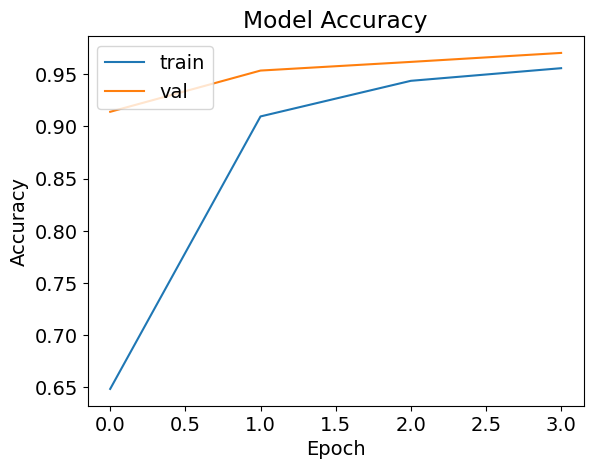

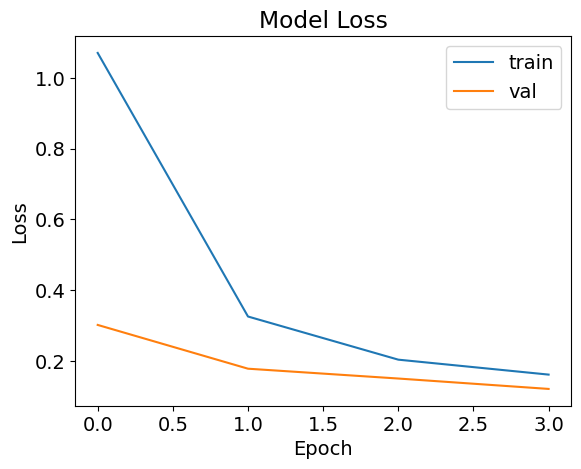

In [22]:
plot_loss_acc(vit_history)

In [23]:
vit_score = vit.evaluate(test_dataset, verbose='auto')
print("Vision Transformer classifier evaluation results:\n")
print('Testset Loss = {:.5f}'.format(vit_score[0]))
print('Testset Accuracy = {:.3f}'.format(vit_score[1]))
print('Testset Precision = {:.3f}'.format(vit_score[2]))
print('Testset Recall = {:.3f}'.format(vit_score[3]))

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9638 - loss: 0.1480 - precision: 0.9652 - recall: 0.9633
Vision Transformer classifier evaluation results:

Testset Loss = 0.12148
Testset Accuracy = 0.970
Testset Precision = 0.972
Testset Recall = 0.969


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


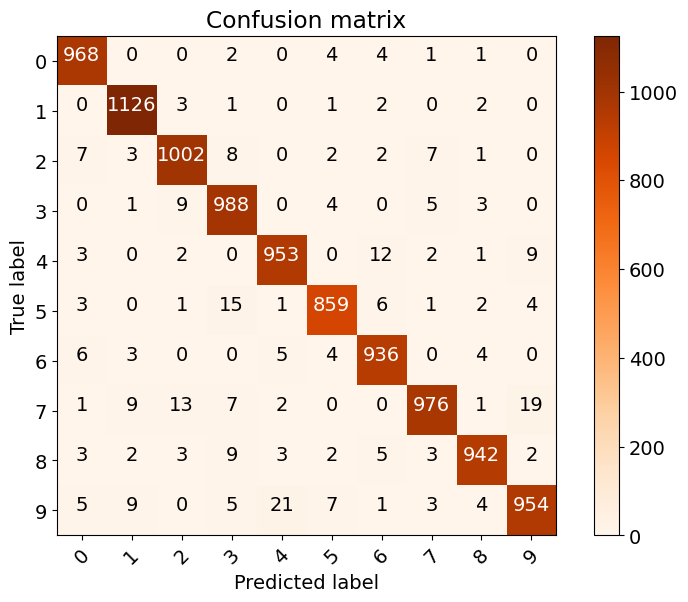

In [24]:
plot_confusion_matrix(vit)